# Churn Prediction - Exploratory Data Analysis
Author: Daniel Grzebyk

Date: 7.08.2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2

from classification_utils import chi_test, find_boolean_features

## Loading the data

In [2]:
df = pd.read_csv("data/telecom/data.csv")
var_df = pd.read_csv("data/telecom/variables-definition.csv")

## Exploratory Data Analysis (EDA)
Research Question: Why customers leave the company?

Hypothesis to be verified:
- the services are too expensive - if yes, then lower income households would leave more frequently, as they are more price-sensitive
- the services are not required - if yes, few calls, low data usage, etc.
- low quality of service - many calls failed due to network issues
- geography: maybe in some geographical areas (lower network coverage or income)
- are household with children more loyal customers?

Relevant Observations:
- Data Structure: every row is a customer / household
- Problem: binary classification problem: predict whether a customer will stay with the telecom company or leave
- Label: churn - the customer will leave [yes / no]

Interesting features
- Failed calls might indicate issues with the quality of service. What % of all calls fails, and how does it influence customer loyalty?
- Time spent calling customer service, happy customers rarely call.

Features not relevant for predicting churn:
- Number and minutes of unanswered and received calls
- Whether calls are wireless or not
- Network traffic, whether call is peak or off-peak
- The number of call participants
- Whether calls are incoming or outbound
- Distinction between voice and data calls

### Loyalty
The distribution is right-skewed, peak around the 12th month might indicate past sale or a marketing campaign. The longest staying customer is with the company for 5 years. 

<AxesSubplot:xlabel='months', ylabel='Count'>

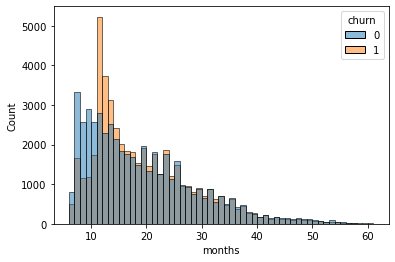

In [3]:
sns.histplot(data=df, x='months', hue='churn', binwidth=1)

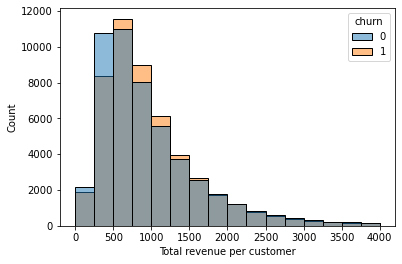

In [4]:
sns.histplot(data=df, x='totrev', hue='churn', binrange=(0, 4000), binwidth=250)
plt.xlabel("Total revenue per customer")
plt.show()

### Company Revenue
As customer requirements are covered by multiple products, in order to check which customers significantly changed their consumption it is the easiest to look at the revenue. It can be seen that around 5% of all customers reduced their spending by at least 50% with respect to the 3 month mean. These customers might be the potential leavers.

After identifying who the potential leavers might be, it will be checked what % of revenue they bring to the company. E.g. suddent outflow of high-revenue clients could be a source of a major concern.

In [5]:
rapid_reduction_rate = round(len(df['change_rev'].loc[df['change_rev'] < -50]) / len(df), 2)
rapid_reduction_rate

0.05

<AxesSubplot:xlabel='avgrev', ylabel='Count'>

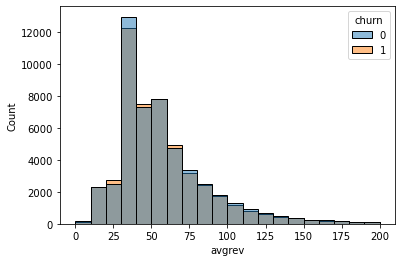

In [6]:
sns.histplot(data=df, x='avgrev', hue='churn', binrange=(0, 200), binwidth=10)

<AxesSubplot:xlabel='avg3rev', ylabel='Count'>

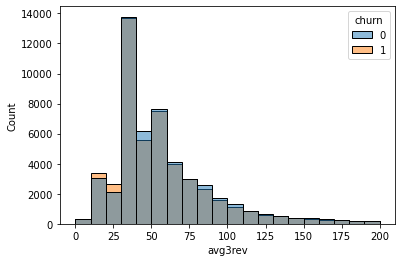

In [7]:
sns.histplot(data=df, x='avg3rev', hue='churn', binrange=(0, 200), binwidth=10)

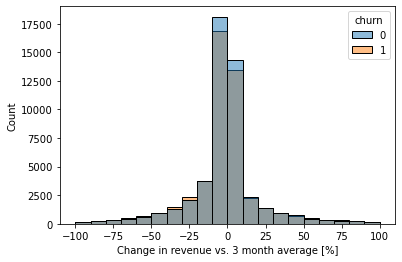

In [8]:
sns.histplot(data=df, x='change_rev', binrange=(-100, 100), binwidth=10, hue='churn')
plt.xlabel("Change in revenue vs. 3 month average [%]")
plt.show()

Customers who use more than they declared in their plan often bear additional costs. Are these costs the reason why they change the service provider? Probably not, as they are usually less than 10% of the overall costs.

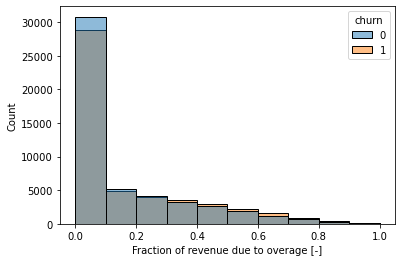

In [9]:
df['overrev_ratio'] = df['ovrrev_Mean'] / df['rev_Mean']
sns.histplot(x='overrev_ratio', data=df, binrange=(0, 1), binwidth=0.1, hue='churn')
plt.xlabel("Fraction of revenue due to overage [-]")
plt.show()
del df['overrev_ratio']

### Demand
Clearly, there are very few customers who pay for the service and not use it. Therefore, rapid drop of demand might be correlated with churn.

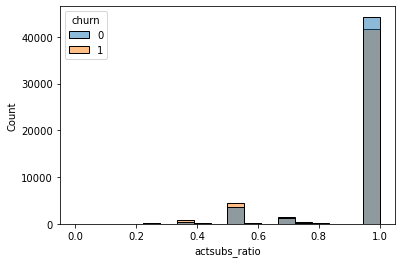

In [10]:
df['actsubs_ratio'] = df['actvsubs'] / df['uniqsubs']
sns.histplot(data=df, x='actsubs_ratio', hue='churn')
del df['actsubs_ratio']

<AxesSubplot:xlabel='avg3mou', ylabel='Count'>

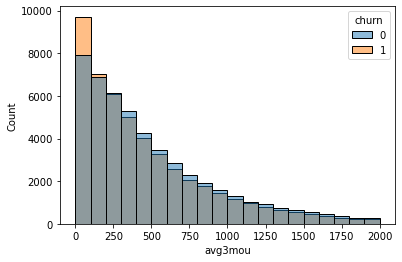

In [11]:
sns.histplot(data=df, x='avg3mou', hue='churn', binrange=(0, 2000), binwidth=100)

### Customers social status
Client income is a categorical variable, but no information about the brackets for each class were provided. It is assumed that income will be the most influencial of all status-related features including also: size of dwelling, credit card information, number of cars, etc. Strong correlations are expected between these features, and perhaps some of them could be removed.

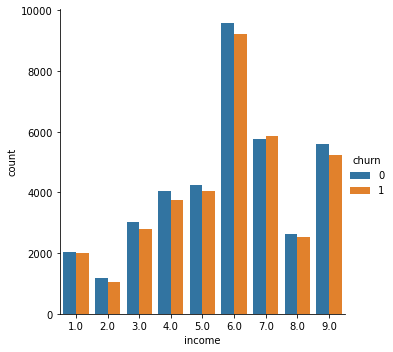

In [12]:
sns.catplot(x="income", hue="churn", data=df, kind="count")

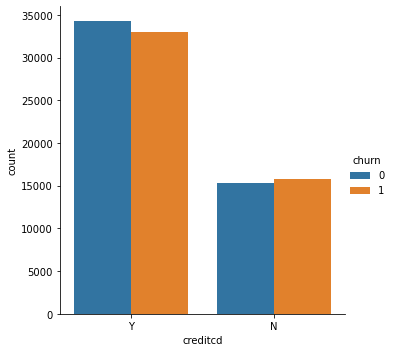

In [13]:
sns.catplot(x="creditcd", hue="churn", data=df, kind="count")

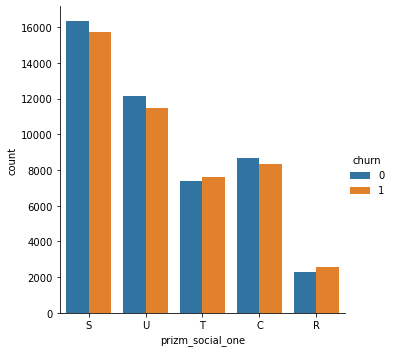

In [14]:
sns.catplot(x="prizm_social_one", hue="churn", data=df, kind="count")

Chi test is used to check whether there is correlation between income and other features related to social status. As expected, all features in this category are correlated which means they not introduce new information to the dataset and therefore are removed. 

In [15]:
maybe_dependent_cols = ['crclscod', 'asl_flag', 'prizm_social_one', 'ownrent', 'lor', 'dwlltype', 'dwllsize', 'numbcars', 
                        'HHstatin', 'forgntvl', 'creditcd']
correlated_features, uncorrelated_features, results_dict = chi_test(df, maybe_dependent_cols, df['income'])
df.drop(columns=correlated_features, inplace=True)

In [16]:
uncorrelated_features

[]

### Household information
How many households have children, and are households with children more loyal customers? The initial hypothesis is the parents of young children are too busy to make changes in telecom providers, but this tendency is expected to disappear as children are older.

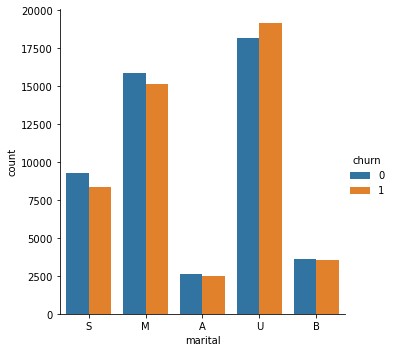

In [17]:
sns.catplot(x="marital", hue="churn", data=df, kind="count")

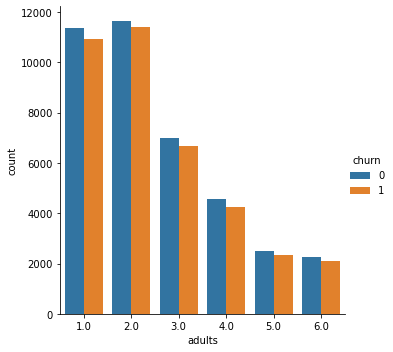

In [18]:
sns.catplot(x="adults", hue="churn", data=df, kind="count")

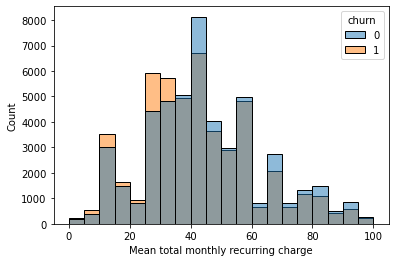

In [19]:
sns.histplot(data=df, x='totmrc_Mean', binrange=(0, 100), binwidth=5, hue='churn')
plt.xlabel("Mean total monthly recurring charge")
plt.show()

### Quality of service
Median time of a call with customer service is 2 min which might mean the issues are resolved relatively quickly.

In [20]:
(df['ccrndmou_Mean'] / df['custcare_Mean']).median()

2.000000003

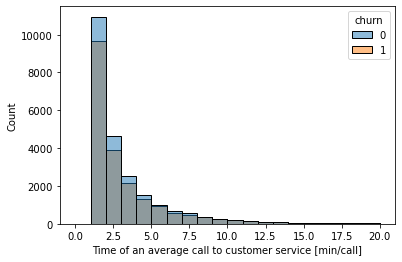

In [21]:
df['custcall_time_Mean'] = df['ccrndmou_Mean'] / df['custcare_Mean']

sns.histplot(data=df, x='custcall_time_Mean', hue='churn', binrange=(0, 20), binwidth=1)
plt.xlabel("Time of an average call to customer service [min/call]")
plt.show()
del df['custcall_time_Mean']

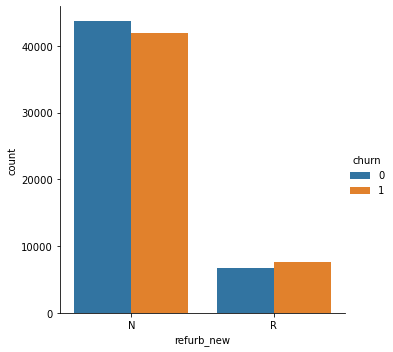

In [22]:
sns.catplot(x="refurb_new", hue="churn", data=df, kind="count")

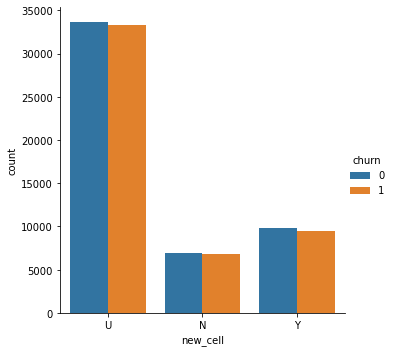

In [23]:
sns.catplot(x="new_cell", hue="churn", data=df, kind="count")

<AxesSubplot:xlabel='hnd_price', ylabel='Count'>

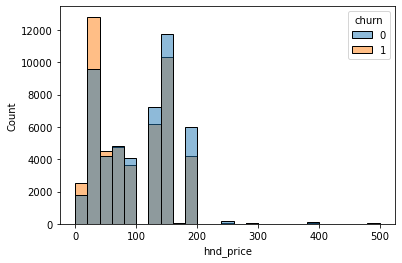

In [24]:
sns.histplot(data=df, x="hnd_price", hue="churn", binwidth=20, binrange=(0, 500))

In [25]:
df['hnd_price'].count()

99153

In [26]:
q1 = df['hnd_price'].quantile(q=0.25)
q3 = df['hnd_price'].quantile(q=0.75)
iqr = q3 - q1

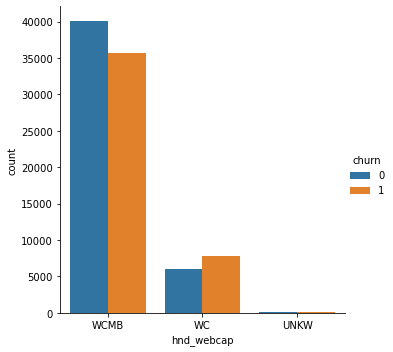

In [27]:
sns.catplot(data=df, x="hnd_webcap", hue="churn", kind="count")

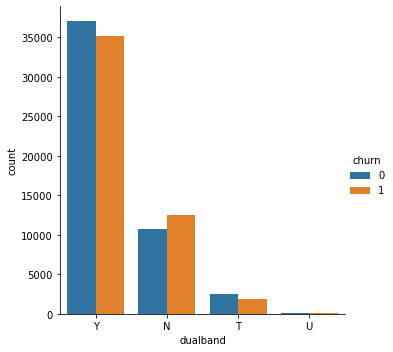

In [28]:
sns.catplot(data=df, x="dualband", hue="churn", kind="count")

High percentage of failed calls or old equipment could indicate low quality of service and influence customer churn. It does not matter whether headset is refurbished or new, churn value is evenly distributed. 

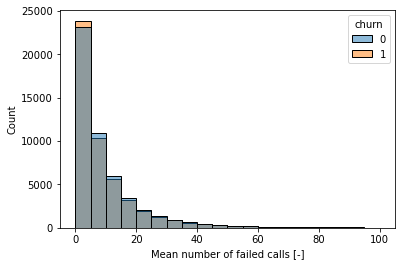

In [29]:
df['failed_calls'] = df['drop_vce_Mean'] + df['drop_dat_Mean'] + df['blck_vce_Mean'] + df['blck_dat_Mean']
sns.histplot(data=df, x='failed_calls', hue='churn', binrange=(0, 100), binwidth=5)
plt.xlabel("Mean number of failed calls [-]")
plt.show()
del df['failed_calls']

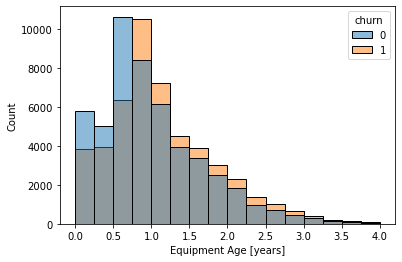

In [30]:
df['eqpyears'] = df['eqpdays'] / 365
sns.histplot(data=df, x='eqpyears', hue='churn', binrange=(0, 4), binwidth=0.25)
plt.xlabel("Equipment Age [years]")
plt.show()
del df['eqpyears']

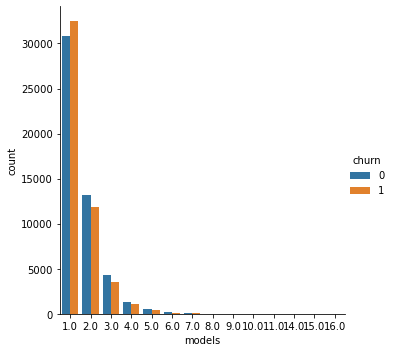

In [31]:
sns.catplot(data=df, x='models', hue='churn', kind='count') # , binrange=(0, 20), binwidth=1

### Other
Churn is more or less equally distributed across all areas of operation. Non-uniform distribution could undicate e.g. new strong competition. 

<AxesSubplot:>

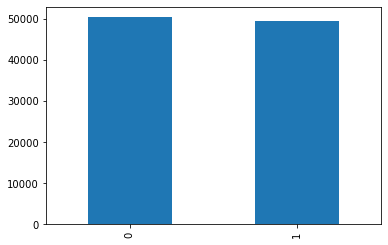

In [32]:
df['churn'].value_counts().plot(kind='bar')

## Chi test

In [33]:
cat_features = df.select_dtypes(include='object').columns

my_x = df[cat_features].dropna().copy()
my_y = df['churn'].loc[my_x.index]

one_hot = OneHotEncoder(sparse=False)  # handle_unknown='ignore'
my_x_enc = one_hot.fit_transform(my_x)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(my_x_enc, my_y)

X_train_chi = chi2_selector.transform(my_x_enc)

In [34]:
feature_names = one_hot.get_feature_names(cat_features)

chi_df = pd.DataFrame({"feature": feature_names, "score": chi2_selector.scores_, "p_value": chi2_selector.pvalues_})
chi_df.loc[chi_df['p_value'] < 0.05].sort_values(by='p_value').head(50)

,feature,score,p_value
29,hnd_webcap_WC,311.278190,1.150221e-69
54,ethnic_Z,122.827290,1.521315e-28
48,ethnic_O,81.442268,1.804569e-19
27,refurb_new_R,71.981433,2.172317e-17
16,area_NORTHWEST/ROCKY MOUNTAIN AREA,64.364388,1.034105e-15
30,hnd_webcap_WCMB,58.362259,2.180338e-14
22,dualband_N,52.025357,5.478853e-13
23,dualband_T,51.094387,8.802966e-13
12,area_MIDWEST AREA,27.512503,1.560822e-07
39,ethnic_C,24.972307,5.815970e-07


In [35]:
beginnings = chi_df['feature'].apply(lambda x: x.split("_")[:-1])
beginnings.values#.unique()

array([list(['new', 'cell']), list(['new', 'cell']),
       list(['new', 'cell']), list(['area']), list(['area']),
       list(['area']), list(['area']), list(['area']), list(['area']),
       list(['area']), list(['area']), list(['area']), list(['area']),
       list(['area']), list(['area']), list(['area']), list(['area']),
       list(['area']), list(['area']), list(['area']), list(['area']),
       list(['area']), list(['dualband']), list(['dualband']),
       list(['dualband']), list(['dualband']), list(['refurb', 'new']),
       list(['refurb', 'new']), list(['hnd', 'webcap']),
       list(['hnd', 'webcap']), list(['hnd', 'webcap']),
       list(['marital']), list(['marital']), list(['marital']),
       list(['marital']), list(['marital']), list(['infobase']),
       list(['infobase']), list(['ethnic']), list(['ethnic']),
       list(['ethnic']), list(['ethnic']), list(['ethnic']),
       list(['ethnic']), list(['ethnic']), list(['ethnic']),
       list(['ethnic']), list(['ethnic

<AxesSubplot:xlabel='feature'>

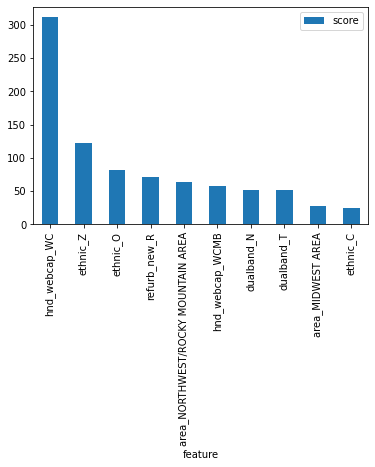

In [36]:
chi_df.nsmallest(10, columns=['p_value']).plot(x='feature', y='score', kind='bar')

## Clustering
Clustering is used to gain further insight in the data without plotting each feature manually. 

In [37]:
num_features = df.select_dtypes(include='number').columns
X = df[num_features].copy()

X.isna().sum().sort_values(ascending=False).head()

income     25436
adults     23019
avg6mou     2839
avg6qty     2839
avg6rev     2839
dtype: int64

In [38]:
X.drop(columns=['Customer_ID', 'churn'], inplace=True) # 'income', 'adults', 
X.dropna(inplace=True)
print(X.shape)

(71574, 74)


In [39]:
%%time
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    distorsions.append(kmeans.inertia_)

Wall time: 21.1 s


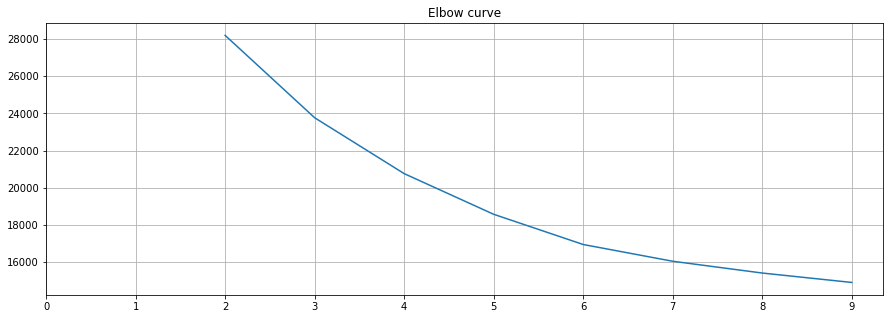

In [40]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.xticks(np.arange(0, 10, 1))
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [122]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)

KMeans(n_clusters=2)

In [123]:
kmeans.inertia_

28201.159233524177

In [124]:
# X['cluster'] = kmeans.labels_
# print(X.groupby("churn")['cluster'].value_counts())
# del X['cluster']

In [125]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

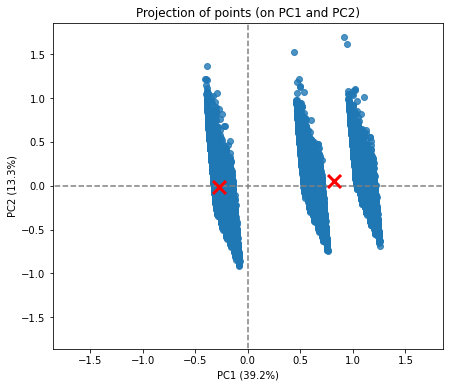

In [126]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(X_scaled)

# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = kmeans.labels_
X_reduceddf.head()

centres_reduced = pca.transform(kmeans.cluster_centers_)

display_factorial_planes(X_reduced, 2, pca, [(0,1)], alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

In [127]:
y = df['churn'].loc[X.index]
new_df = pd.DataFrame({"churn":y.values, "cluster":kmeans.labels_})
new_df['cluster'].value_counts()

1    53722
0    17852
Name: cluster, dtype: int64

In [128]:
new_df.groupby("cluster")['churn'].value_counts()

cluster  churn
0        0         9041
         1         8811
1        0        27386
         1        26336
Name: churn, dtype: int64

In [129]:
palette = sns.color_palette("bright", 10)

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(24, 10))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)
    plt.xticks(rotation = 90)
#     plt.ylim([0, 0.2])

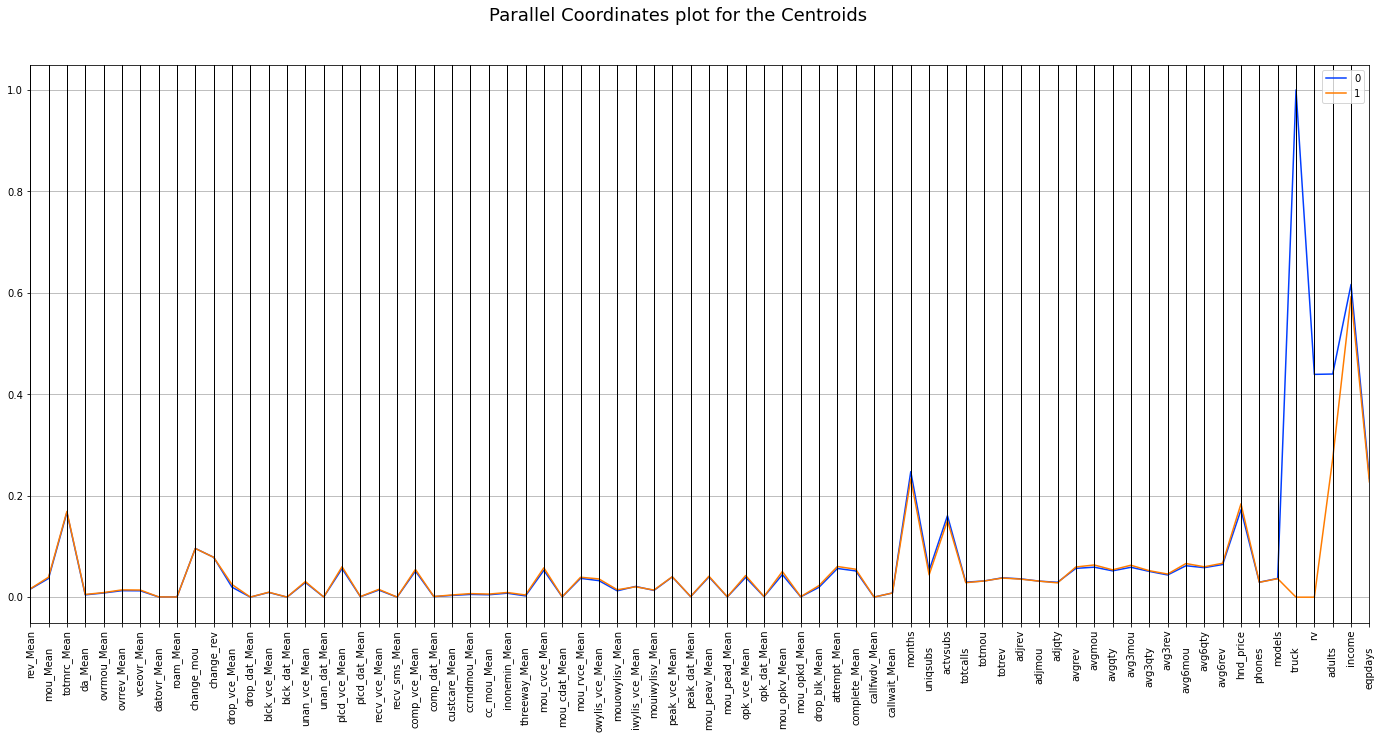

In [130]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 2)

In [131]:
mydf = centroids.diff().abs().dropna().T
mydf.rename(columns={1:"difference"}, inplace=True)
mydf.loc[mydf['difference'] > 0.006].sort_values(by='difference', ascending=False)  #.head()
# mydf.head()
mydf.sort_values(by='difference', ascending=False).head(20)

,difference
truck,1.000000
cluster,1.000000
rv,0.439222
adults,0.166874
income,0.023858
months,0.014269
hnd_price,0.011878
actvsubs,0.009650
uniqsubs,0.008436
eqpdays,0.006937


In [132]:
selected_features = list(mydf.loc[mydf['difference'] > 0.006].index)
selected_features

['mou_opkv_Mean',
 'months',
 'uniqsubs',
 'actvsubs',
 'hnd_price',
 'truck',
 'rv',
 'adults',
 'income',
 'eqpdays',
 'cluster']

<AxesSubplot:xlabel='eqpdays', ylabel='Count'>

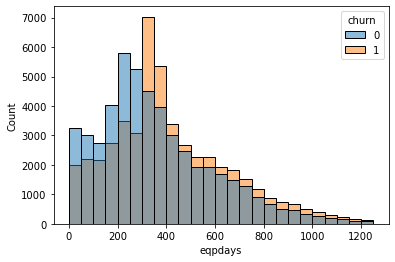

In [47]:
sns.histplot(data=df, x='eqpdays', hue='churn', binrange=(0, 1250), binwidth=50)

<AxesSubplot:xlabel='hnd_price', ylabel='Count'>

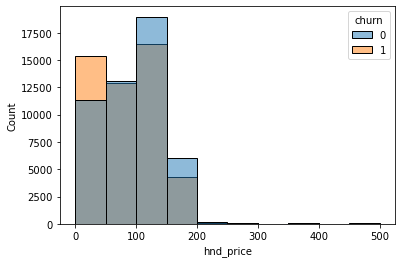

In [48]:
sns.histplot(data=df, x='hnd_price', hue='churn', binrange=(0, 500), binwidth=50)

<AxesSubplot:xlabel='mou_opkv_Mean', ylabel='Count'>

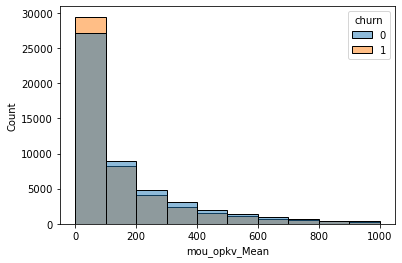

In [49]:
sns.histplot(data=df, x='mou_opkv_Mean', hue='churn', binrange=(0, 1000), binwidth=100)

<AxesSubplot:xlabel='totmrc_Mean', ylabel='Count'>

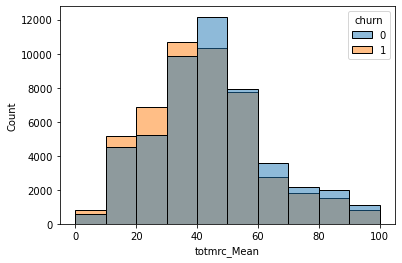

In [50]:
# .loc[df['totmrc_Mean'] < 100]
sns.histplot(data=df, x='totmrc_Mean', hue='churn', binrange=(0, 100), binwidth=10)

<AxesSubplot:xlabel='avgmou', ylabel='Count'>

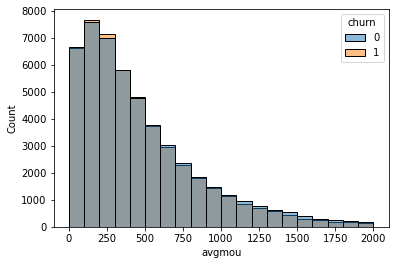

In [51]:
sns.histplot(data=df, x='avgmou', hue='churn', binrange=(0, 2000), binwidth=100)

<AxesSubplot:xlabel='avg3mou', ylabel='Count'>

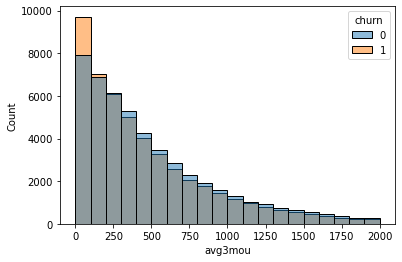

In [52]:
sns.histplot(data=df, x='avg3mou', hue='churn', binrange=(0, 2000), binwidth=100)

<AxesSubplot:xlabel='avg6mou', ylabel='Count'>

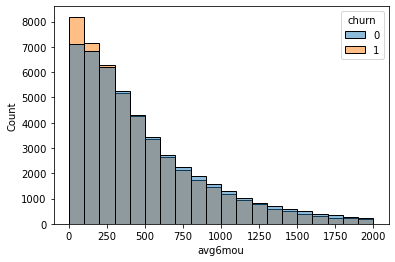

In [53]:
sns.histplot(data=df, x='avg6mou', hue='churn', binrange=(0, 2000), binwidth=100)

<AxesSubplot:xlabel='mou_cvce_Mean', ylabel='Count'>

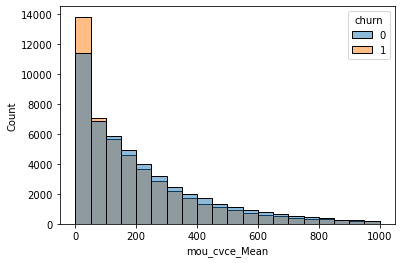

In [54]:
sns.histplot(data=df, x='mou_cvce_Mean', hue='churn', binrange=(0, 1000), binwidth=50)

<AxesSubplot:xlabel='attempt_Mean', ylabel='Count'>

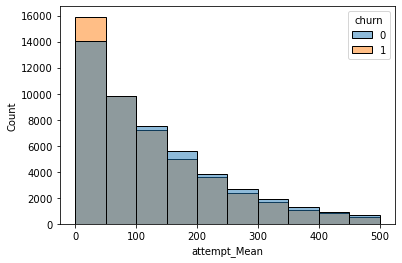

In [55]:
sns.histplot(data=df, x='attempt_Mean', hue='churn', binrange=(0, 500), binwidth=50)

<AxesSubplot:xlabel='complete_Mean', ylabel='Count'>

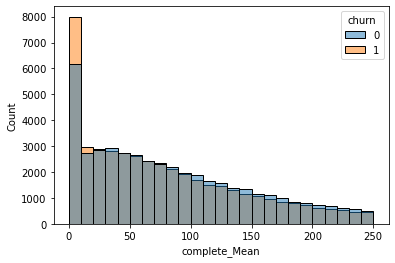

In [57]:
sns.histplot(data=df, x='complete_Mean', hue='churn', binrange=(0, 250), binwidth=10)

<AxesSubplot:xlabel='plcd_vce_Mean', ylabel='Count'>

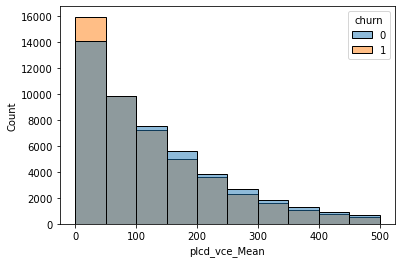

In [56]:
sns.histplot(data=df, x='plcd_vce_Mean', hue='churn', binrange=(0, 500), binwidth=50)

<AxesSubplot:xlabel='comp_vce_Mean', ylabel='Count'>

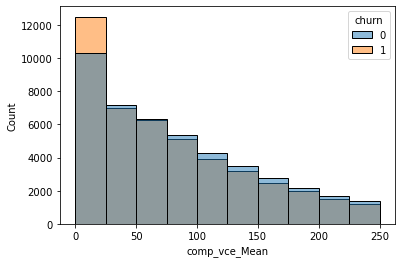

In [58]:
sns.histplot(data=df, x='comp_vce_Mean', hue='churn', binrange=(0, 250), binwidth=25)

## EDA Conclusions
Average customer who leaves uses cheaper and older handset than the customer who stays. Demographic features such as number of kids and marital status, or status features such as income and number of cars are equally distributed between churners and non-churners, and therefore have no influence on churn.